In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np

import os
from pathlib import Path

from torchsummary import summary
import shutil

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

Let's build a simple MNIST model, with only 6 layers. Global Average Pooling (GAP) and dense layers are used at last for consistent weights.

In [2]:
log_batch = 10
unit_num = 16

def _make_layer(in_shape, out_shape, unit_num):
    return nn.Sequential(
        nn.Conv2d(in_shape, unit_num, 3, 1, 1),
        nn.ReLU(inplace=True),
        nn.Conv2d(unit_num, out_shape, 3, 1, 1),
        nn.ReLU(inplace=True),
    )
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = _make_layer(1,unit_num,unit_num)
        self.layer2 = _make_layer(unit_num,unit_num*2,unit_num*2)
        self.layer3 = _make_layer(unit_num*2,unit_num*4,unit_num*4)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(unit_num*4, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        
        x = self.layer3(x)
        x = self.gap(x)
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



use_cuda = torch.cuda.is_available()
model = Net()
if use_cuda:
    model = model.cuda()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
              ReLU-8           [-1, 32, 14, 14]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
             ReLU-12             [-1, 64, 7, 7]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Linear-14                   

Dataset are stored in '/dataset'. If you want to change this, remember to change the root for ClassesLoader.

In [3]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.MNIST(root = "./dataset",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./dataset",
                           transform = transform,
                           train = False)
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                 num_workers=0)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = batch_size,
                                               shuffle = True,
                                                num_workers=0)

We do not want a perfect MNIST classifier. Around 97% accuracy is enough for the explanations.

In [4]:
if not os.path.exists(Path('model')):
    os.mkdir(Path('model'))

RETRAIN = False
MODEL_PATH = Path('model/MNIST_model.pt') 

if not os.path.exists(MODEL_PATH) or RETRAIN:

    cost = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    n_epochs = 10
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_correct = 0
        print("Epoch {}/{}".format(epoch, n_epochs))
        print("-"*10)
        for data in data_loader_train:
            X_train, y_train = data
            if use_cuda:
                X_train, y_train = X_train.cuda(), y_train.cuda()
            outputs = F.softmax(model(X_train))
            _,pred = torch.max(outputs.data, 1)
            optimizer.zero_grad()
            loss = cost(outputs, y_train)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += torch.sum(pred == y_train.data).item()
        testing_correct = 0
        for data in data_loader_test:
            X_test, y_test = data
            if use_cuda:
                X_test, y_test = X_test.cuda(), y_test.cuda()
            outputs = model(X_test)
            _, pred = torch.max(outputs.data, 1)
            testing_correct += torch.sum(pred == y_test.data).item()
        print("Loss is:{:.8f}, Train Accuracy is:{:.2f}%, Test Accuracy is:{:.2f}%".format(running_loss*batch_size/len(data_train),
                                                                                          100*running_correct/len(data_train),
                                                                                          100*testing_correct/len(data_test)))
        
    torch.save(model.state_dict(),MODEL_PATH)
else:
    model.load_state_dict(torch.load(MODEL_PATH))
    print ('model loaded!')

model loaded!


Now, for the Explanations.
1. Create a loader list. Each loader only contains samples from one class.
2. Wrap the model. Set all explanation related classes.
3. create Explainer, train the model and generate explanations.

Here we choose [1,2,4,8] as target classes

In [5]:
import ICE.ModelWrapper
import ICE.Explainer
import ICE.utils
import shutil


target_classes = [3,8]
classes_names = [str(i) for i in target_classes]
layer_name = 'layer3'
n_components = 10
title = "MNIST_{}_{}_[".format(layer_name,n_components)+"_".join(classes_names) + ']'



print ("title:{}".format(title))
print ("target_classes:{}".format(target_classes))
print ("classes_names:{}".format(classes_names))
print ("n_components:{}".format(n_components))
print ("layer_name:{}".format(layer_name))

title:MNIST_layer3_10_[3_8]
target_classes:[3, 8]
classes_names:['3', '8']
n_components:10
layer_name:layer3


In [6]:


model = model.cuda()
model.eval()
wm = ICE.ModelWrapper.PytorchModelWrapper(model,batch_size=batch_size,predict_target=target_classes,input_size = [1,28,28],input_channel_first = True,model_channel_first = True)


In [7]:
X,y = data_train.data,data_train.targets
loaders = []
for target in target_classes:
    tdataset = torch.utils.data.TensorDataset(X[y==target].unsqueeze(1))
    loaders.append(torch.utils.data.DataLoader(tdataset,batch_size=batch_size))

In [8]:

print ("-------------------------------------------------------------------------------------------")

try:
    shutil.rmtree('Explainers/'+title)
except:
    pass
# create an Explainer
Exp = ICE.Explainer.Explainer(title = title,
                layer_name = layer_name,
                class_names = classes_names,
                utils = ICE.utils.img_utils(img_size = (28,28),nchannels=1,img_format='channels_first'),
                n_components = n_components,
                reducer_type = "NMF"
               )

# train reducer based on target classes
Exp.train_model(wm,loaders)
# generate features 
Exp.generate_features(wm, loaders)
# generate global explanations
Exp.global_explanations()
# save the explainer, use load() to load it with the same title
Exp.save()


-------------------------------------------------------------------------------------------
Training reducer:
1/5 Featuer maps gathered.
loading complete, with size of (11982, 7, 7, 64)
2/5 Reducer trained, spent 6.036442279815674 s.
3/5 Error estimated, fidelity: [0.06354667 0.0652013 ].
4/5 Weight estimator initialized.
5/5 Weight estimated.
visulizing features:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
loading training data
Done with class: 3, 1/2
Done with class: 8, 2/2
Generate explanations with fullset condition


In [9]:
# you can load exist explainers with title
Exp = ICE.Explainer.Explainer(title = title)
Exp.load()

Global Explanations for 1,2,4,8

In [10]:
from IPython.display import HTML, display
import os
fpath = os.path.join("Explainers",title,"GE")
paths = [os.path.join(fpath,fname) for fname in os.listdir(fpath)]
display(HTML("".join(["<table><tr>"]+["<td><img src='{}'></td>".format(path) for path in paths]+["</tr></table>"])))

,


Local explanations for a '3'

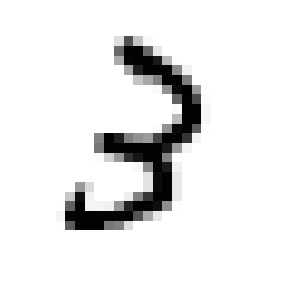

In [11]:
x = data_test.data[data_test.targets==3][5]
x = x.unsqueeze(0)
Exp.utils.show_img([Exp.utils.deprocessing(x.permute(0,2,1).numpy())])
x = x.numpy()

In [12]:
Exp.local_explanations(x,wm)

In [13]:
from IPython.display import HTML, display
import os
fpath = os.path.join("Explainers",title,"explanations","0")
paths = [os.path.join(fpath,fname) for fname in os.listdir(fpath) if 'explanation' in fname]
display(HTML("".join(["<table><tr>"]+["<td><img src='{}'></td>".format(path) for path in paths]+["</tr></table>"])))

,
